# Hildebrand Local Thickness Algorithm Notebook

Investigate the local thickness of structures in Python.

In [32]:
import numpy as np
import SimpleITK as sitk
from itkwidgets import compare, view
from matplotlib import pyplot as plt

from ormir_xct.util.hildebrand_thickness import calc_structure_thickness_statistics

Synthetic shape mask functions:

In [50]:
def create_shape(shape, voxel_widths, thickness, shape_type="sphere"):
    center = (
        voxel_widths[0] * (shape[0] // 2), 
        voxel_widths[1] * (shape[1] // 2), 
        voxel_widths[2] * (shape[2] // 2)
    )
    x, y, z = np.meshgrid(*[voxel_widths[i] * np.arange(0, shape[i]) for i in range(3)], indexing="ij")
    if shape_type == "sphere":
        mask = (((x-center[0])**2 + (y-center[1])**2 + (z-center[2])**2) < (thickness/2)**2).astype(int)
    elif shape_type == "cylinder":
        mask = (((x-center[0])**2 + (y-center[1])**2) < (thickness/2)**2).astype(int)
    elif shape_type == "plate":
        mask = (np.abs(x-center[0]) <= thickness/2).astype(int)
    else:
        raise ValueError(f"`shape_type` can be `sphere`, `cylinder`, `plate`; got {shape_type}")
    return mask

    

Generate a synthetic sphere, cylinder, and plate:

In [51]:
shape = tuple([50]*3)
voxel_widths = tuple([0.0607]*3)
radius = 1

sphere = create_shape(shape, voxel_widths, radius, shape_type="sphere")
cylinder = create_shape(shape, voxel_widths, radius, shape_type="cylinder")
plate = create_shape(shape, voxel_widths, radius, shape_type="plate")

compare(sphere, cylinder, link_cmap=True, axes=True, rotate=True)

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=True, description='cmap'), Checkbox(va…

In [52]:
compare(sphere, plate, link_cmap=True, axes=True, rotate=True)

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=True, description='cmap'), Checkbox(va…

Check their estimated mean thicknesses:

In [53]:
sphere_thickness_stats = calc_structure_thickness_statistics(sphere, voxel_widths, 0)
cylinder_thickness_stats = calc_structure_thickness_statistics(cylinder, voxel_widths, 0)
plate_thickness_stats = calc_structure_thickness_statistics(plate, voxel_widths, 0)

In [54]:
print(f"Sphere thickness is {sphere_thickness_stats[0]:0.3f} +/- {sphere_thickness_stats[1]:0.3f}")
print(f"Cylinder thickness is {cylinder_thickness_stats[0]:0.3f} +/- {cylinder_thickness_stats[1]:0.3f}")
print(f"Plate thickness is {plate_thickness_stats[0]:0.3f} +/- {plate_thickness_stats[1]:0.3f}")

Sphere thickness is 1.001 +/- 0.000
Cylinder thickness is 0.953 +/- 0.179
Plate thickness is 1.053 +/- 0.129


This checks out because we set `radius = 1` when we generated these shapes.

Now we can do a sweep over spheres, cylinders, and plates of various thicknesses to see how well we can estimate the thickness of these shapes at various resolutions.

In [55]:
shape = (100, 100, 100)
voxel_widths = (1, 1, 1)

true_thicknesses = np.arange(2, 40, 4)

est_sph_thicknesses = []
est_cyl_thicknesses = []
est_plt_thicknesses = []

for thickness in true_thicknesses:
    print(f"thickness: {thickness}")
    
    sphere = create_shape(shape, voxel_widths, thickness, shape_type="sphere")
    est_sph_thicknesses.append(calc_structure_thickness_statistics(sphere, voxel_widths, 0)[0])
    
    cylinder = create_shape(shape, voxel_widths, thickness, shape_type="cylinder")
    est_cyl_thicknesses.append(calc_structure_thickness_statistics(cylinder, voxel_widths, 0)[0])
    
    plate = create_shape(shape, voxel_widths, thickness, shape_type="plate")
    est_plt_thicknesses.append(calc_structure_thickness_statistics(plate, voxel_widths, 0)[0])

thickness: 2
thickness: 6
thickness: 10
thickness: 14
thickness: 18
thickness: 22
thickness: 26
thickness: 30
thickness: 34
thickness: 38


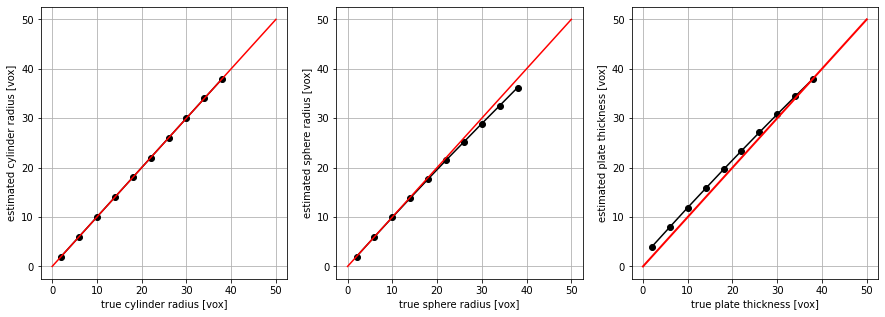

In [62]:
max_size = max(shape)//2

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(true_thicknesses, est_sph_thicknesses, "k-o")
axs[0].plot([0, max_size], [0, max_size], "r-")
axs[0].grid()

axs[0].set_xlabel("true cylinder radius [vox]")
axs[0].set_ylabel("estimated cylinder radius [vox]")

axs[1].plot(true_thicknesses, est_cyl_thicknesses, "k-o")
axs[1].plot([0, max_size], [0, max_size], "r-")
axs[1].grid()

axs[1].set_xlabel("true sphere radius [vox]")
axs[1].set_ylabel("estimated sphere radius [vox]")

axs[2].plot(true_thicknesses, est_plt_thicknesses, "k-o")
axs[2].plot([0, max_size], [0, max_size], "r-", linewidth=2)
axs[2].grid()

axs[2].set_xlabel("true plate thickness [vox]")
axs[2].set_ylabel("estimated plate thickness [vox]")

plt.show()